In [132]:
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import geopandas as gpd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.font_manager as fm
from matplotlib import font_manager, rc
import seaborn as sns
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from numpy import dot 
from numpy.linalg import norm
from libpysal.weights.contiguity import Queen
import splot
from esda.moran import Moran
from splot.esda import moran_scatterplot
from tqdm.notebook import tqdm
from scipy import stats
import os
import copy
import time

mpl.rcParams['axes.unicode_minus'] = False
warnings.simplefilter('ignore')

font_path = r'C:/Users/user/NanumFontSetup_TTF_ALL/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=font_path, size=18).get_name()
rc('font',family=font_name)

# 1. Data Load

In [133]:
data_path = '../data/Dataset' 
os.listdir(data_path)

['fixed_dataset(매출건수).csv',
 'fixed_dataset(자동차유지,10퍼센트절사평균).csv',
 'fixed_dataset(자동차제거,null유지).csv',
 'fixed_dataset(자동차제거,매출log,null유지).csv',
 'fixed_dataset(자동차제거,매출log,null유지,절사평균).csv',
 'fixed_dataset(자동차제거,매출raw,null유지).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,1126).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,1201).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,원래연면적,1201).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,원래연면적,버퍼점포밀도,1202).csv',
 'fixed_dataset.csv',
 'fixed_dataset_1105.csv',
 'fixed_dataset_1214.csv']

In [134]:
# 1. 매출 log, null 유지
data = pd.read_csv(os.path.join(data_path,'fixed_dataset_1214.csv'),encoding='euc-kr')

# 2. 자동차제거,매출log,null유지,절사평균
# data = pd.read_csv(os.path.join(data_path,'fixed_dataset(자동차제거,매출log,null유지,절사평균).csv'),encoding='euc-kr')
data.head()

,BAS_ID,BAS_AR,도로길이고려_전체통합도,도로길이고려_국부통합도_R3,기초구역평균_전체통합도,기초구역평균_국부통합도_R3,도로율,평균 도로 길이,아파트시세변화_차분평균,평균영업기간,...,서비스업종다양성,소매업종다양성,상가밀도,주중 / 주말,06 to 18 / 18 to 06,개별공시지가 변화 차분평균,(주거인구+직장인구) / 유동인구,주거인구/직장인구,10_30 / 40_60,점포밀도
0,21300,0.743330,617.130076,7987.604945,0.060037,0.907932,7.332336,119.253463,0.000,163.106482,...,1.609438,2.390980,86.099041,2.342449,2.695669,31337.73585,0.268398,0.149563,0.406896,7.046875
1,21301,0.121045,221.397046,2876.534944,0.069661,0.938454,30.948119,211.340833,305.909,156.249615,...,1.127535,1.985080,346.978396,2.315147,2.280277,344640.00000,0.254881,0.667946,0.439757,11.523810
2,21302,0.175777,341.252878,4162.583064,0.087372,1.084619,25.546905,214.144187,0.000,111.950730,...,2.029155,1.314799,876.110071,2.064957,2.339853,174949.46240,0.220317,0.899425,0.508371,143.584416
3,21303,0.270679,475.038010,6080.093135,0.084712,1.079401,15.517121,105.011320,912.500,153.728003,...,2.364045,2.064017,232.748015,2.273528,2.246297,97041.79104,0.108296,6.308614,0.441902,36.111111
4,21304,0.073319,273.241567,3575.514233,0.092931,1.107098,32.713927,134.361765,369.231,177.329451,...,2.289920,2.379112,2495.942389,2.016228,2.004099,166589.33650,0.212989,1.959390,0.479893,113.836066


In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BAS_ID               161 non-null    int64  
 1   BAS_AR               161 non-null    float64
 2   도로길이고려_전체통합도         161 non-null    float64
 3   도로길이고려_국부통합도_R3      161 non-null    float64
 4   기초구역평균_전체통합도         161 non-null    float64
 5   기초구역평균_국부통합도_R3      161 non-null    float64
 6   도로율                  161 non-null    float64
 7   평균 도로 길이             161 non-null    float64
 8   아파트시세변화_차분평균         161 non-null    float64
 9   평균영업기간               158 non-null    float64
 10  평균폐업기간               151 non-null    float64
 11  평균최근접역거리             160 non-null    float64
 12  평균최근접정류장거리           160 non-null    float64
 13  건물노후도                161 non-null    float64
 14  공동주택 비율              161 non-null    float64
 15  근린생활시설 비율            161 non-null    flo

## 1.1 결측치 확인

In [136]:
data.isnull().sum()

BAS_ID                  0
BAS_AR                  0
도로길이고려_전체통합도            0
도로길이고려_국부통합도_R3         0
기초구역평균_전체통합도            0
기초구역평균_국부통합도_R3         0
도로율                     0
평균 도로 길이                0
아파트시세변화_차분평균            0
평균영업기간                  3
평균폐업기간                 10
평균최근접역거리                1
평균최근접정류장거리              1
건물노후도                   0
공동주택 비율                 0
근린생활시설 비율               0
단독주택 비율                 0
아파트 가구수                 0
외식업매출월평균변화량             4
서비스업매출월평균변화량            3
소매업매출월평균변화량             5
외식업매출비율                 8
서비스업매출비율                5
소매업매출비율                 5
외식업종다양성                 1
서비스업종다양성                1
소매업종다양성                 1
상가밀도                    1
주중 / 주말                 0
06 to 18 / 18 to 06     0
개별공시지가 변화 차분평균          0
(주거인구+직장인구) / 유동인구      0
주거인구/직장인구               0
10_30 / 40_60           0
점포밀도                    1
dtype: int64

### 1.1.1 평균운영기간, 평균폐업기간
- 영업기간, 폐업기간 둘 다 없을 경우 제거
- 영업기간은 있지만 폐업기간이 없을 경우 영업기간으로 대체
- 점포밀도가 무한대인 row 제거

In [137]:
data[data['평균폐업기간'].isnull()][['BAS_ID','평균영업기간','평균폐업기간','점포밀도']]

,BAS_ID,평균영업기간,평균폐업기간,점포밀도
22,21322,201.466149,NaN,2.666667
27,21327,89.858108,NaN,12.000000
39,21339,82.104355,NaN,0.000000
72,21372,NaN,NaN,28.500000
73,21373,252.747147,NaN,26.633333
75,21375,NaN,NaN,2.000000
81,21381,183.029083,NaN,16.920000
86,21386,132.306618,NaN,10.750000
159,21459,165.177930,NaN,2.666667
160,21460,NaN,NaN,NaN


In [138]:
# 제거할 row 정의 및 제거

drop_index = list(data[data['평균폐업기간'].isnull()].index)

clean_data = data.drop(drop_index,axis=0).reset_index(drop=True)

In [139]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BAS_ID               151 non-null    int64  
 1   BAS_AR               151 non-null    float64
 2   도로길이고려_전체통합도         151 non-null    float64
 3   도로길이고려_국부통합도_R3      151 non-null    float64
 4   기초구역평균_전체통합도         151 non-null    float64
 5   기초구역평균_국부통합도_R3      151 non-null    float64
 6   도로율                  151 non-null    float64
 7   평균 도로 길이             151 non-null    float64
 8   아파트시세변화_차분평균         151 non-null    float64
 9   평균영업기간               151 non-null    float64
 10  평균폐업기간               151 non-null    float64
 11  평균최근접역거리             151 non-null    float64
 12  평균최근접정류장거리           151 non-null    float64
 13  건물노후도                151 non-null    float64
 14  공동주택 비율              151 non-null    float64
 15  근린생활시설 비율            151 non-null    flo

In [140]:
condition = clean_data['외식업매출월평균변화량'].isnull() | clean_data['소매업매출월평균변화량'].isnull() 
clean_data[condition].loc[:,['BAS_ID','외식업매출월평균변화량','서비스업매출월평균변화량','소매업매출월평균변화량']]

,BAS_ID,외식업매출월평균변화량,서비스업매출월평균변화량,소매업매출월평균변화량
103,21411,NaN,-20473.33684,-423603.6429


In [141]:
clean_data.fillna(0,inplace=True)

In [142]:
# null값은 없다.
clean_data.isnull().sum()

BAS_ID                 0
BAS_AR                 0
도로길이고려_전체통합도           0
도로길이고려_국부통합도_R3        0
기초구역평균_전체통합도           0
기초구역평균_국부통합도_R3        0
도로율                    0
평균 도로 길이               0
아파트시세변화_차분평균           0
평균영업기간                 0
평균폐업기간                 0
평균최근접역거리               0
평균최근접정류장거리             0
건물노후도                  0
공동주택 비율                0
근린생활시설 비율              0
단독주택 비율                0
아파트 가구수                0
외식업매출월평균변화량            0
서비스업매출월평균변화량           0
소매업매출월평균변화량            0
외식업매출비율                0
서비스업매출비율               0
소매업매출비율                0
외식업종다양성                0
서비스업종다양성               0
소매업종다양성                0
상가밀도                   0
주중 / 주말                0
06 to 18 / 18 to 06    0
개별공시지가 변화 차분평균         0
(주거인구+직장인구) / 유동인구     0
주거인구/직장인구              0
10_30 / 40_60          0
점포밀도                   0
dtype: int64

## 1.2 geometry 정보 로딩

In [143]:
basis_area= gpd.read_file('../data/전처리 파일/부평구_기초구역_5181/부평구_기초구역_4326.shp')
basis_area.head()

,BAS_AR,BAS_ID,BAS_MGT_SN,CTP_KOR_NM,MVMN_DE,MVMN_RESN,NTFC_DE,OPERT_DE,SIG_CD,SIG_KOR_NM,center_x,center_y,geometry
0,2.648838,21459,2823700025,인천광역시,None,None,20121221,None,28237,부평구,126.742914,37.474121,"POLYGON ((126.73590 37.48296, 126.73597 37.482..."
1,0.156212,21384,2823700061,인천광역시,None,None,20121221,None,28237,부평구,126.708049,37.489905,"POLYGON ((126.70977 37.49105, 126.70987 37.491..."
2,0.076024,21403,2823700058,인천광역시,None,None,20121221,None,28237,부평구,126.732706,37.489535,"POLYGON ((126.73383 37.48969, 126.73431 37.489..."
3,0.527205,21447,2823700035,인천광역시,None,None,20121221,None,28237,부평구,126.694834,37.482046,"POLYGON ((126.69892 37.48537, 126.69960 37.485..."
4,0.073898,21421,2823700036,인천광역시,None,None,20121221,None,28237,부평구,126.737058,37.484080,"POLYGON ((126.73785 37.48219, 126.73772 37.482..."


In [144]:
use_basis_area = basis_area[['BAS_ID','geometry']]
use_basis_area

,BAS_ID,geometry
0,21459,"POLYGON ((126.73590 37.48296, 126.73597 37.482..."
1,21384,"POLYGON ((126.70977 37.49105, 126.70987 37.491..."
2,21403,"POLYGON ((126.73383 37.48969, 126.73431 37.489..."
3,21447,"POLYGON ((126.69892 37.48537, 126.69960 37.485..."
4,21421,"POLYGON ((126.73785 37.48219, 126.73772 37.482..."
...,...,...
156,21423,"POLYGON ((126.73624 37.48294, 126.73641 37.482..."
157,21441,"POLYGON ((126.70483 37.48126, 126.70465 37.481..."
158,21446,"POLYGON ((126.70290 37.47138, 126.70289 37.471..."
159,21453,"POLYGON ((126.70070 37.46956, 126.70069 37.469..."


In [145]:
clean_data['BAS_ID'] = clean_data['BAS_ID'].astype(str) # string 티입으로 변환
clean_data = clean_data.merge(use_basis_area,how='left',right_on='BAS_ID',left_on='BAS_ID').sort_values(by='BAS_ID')
clean_data.head()

,BAS_ID,BAS_AR,도로길이고려_전체통합도,도로길이고려_국부통합도_R3,기초구역평균_전체통합도,기초구역평균_국부통합도_R3,도로율,평균 도로 길이,아파트시세변화_차분평균,평균영업기간,...,소매업종다양성,상가밀도,주중 / 주말,06 to 18 / 18 to 06,개별공시지가 변화 차분평균,(주거인구+직장인구) / 유동인구,주거인구/직장인구,10_30 / 40_60,점포밀도,geometry
0,21300,0.743330,617.130076,7987.604945,0.060037,0.907932,7.332336,119.253463,0.000,163.106482,...,2.390980,86.099041,2.342449,2.695669,31337.73585,0.268398,0.149563,0.406896,7.046875,"POLYGON ((126.69032 37.52345, 126.69084 37.523..."
1,21301,0.121045,221.397046,2876.534944,0.069661,0.938454,30.948119,211.340833,305.909,156.249615,...,1.985080,346.978396,2.315147,2.280277,344640.00000,0.254881,0.667946,0.439757,11.523810,"POLYGON ((126.69791 37.52246, 126.69791 37.522..."
2,21302,0.175777,341.252878,4162.583064,0.087372,1.084619,25.546905,214.144187,0.000,111.950730,...,1.314799,876.110071,2.064957,2.339853,174949.46240,0.220317,0.899425,0.508371,143.584416,"POLYGON ((126.70466 37.52105, 126.70466 37.521..."
3,21303,0.270679,475.038010,6080.093135,0.084712,1.079401,15.517121,105.011320,912.500,153.728003,...,2.064017,232.748015,2.273528,2.246297,97041.79104,0.108296,6.308614,0.441902,36.111111,"POLYGON ((126.70215 37.51767, 126.70204 37.517..."
4,21304,0.073319,273.241567,3575.514233,0.092931,1.107098,32.713927,134.361765,369.231,177.329451,...,2.379112,2495.942389,2.016228,2.004099,166589.33650,0.212989,1.959390,0.479893,113.836066,"POLYGON ((126.70466 37.52105, 126.70466 37.521..."


In [146]:
center = gpd.GeoDataFrame(clean_data).centroid

clean_data['x'] = center.x
clean_data['y'] = center.y

clean_data.iloc[:,-3:]

,geometry,x,y
0,"POLYGON ((126.69032 37.52345, 126.69084 37.523...",126.689135,37.518708
1,"POLYGON ((126.69791 37.52246, 126.69791 37.522...",126.695459,37.522417
2,"POLYGON ((126.70466 37.52105, 126.70466 37.521...",126.701342,37.522339
3,"POLYGON ((126.70215 37.51767, 126.70204 37.517...",126.698730,37.518981
4,"POLYGON ((126.70466 37.52105, 126.70466 37.521...",126.703419,37.519319
...,...,...,...
146,"POLYGON ((126.70003 37.46834, 126.69995 37.468...",126.695939,37.469443
147,"POLYGON ((126.69459 37.47098, 126.69442 37.470...",126.692372,37.471208
148,"POLYGON ((126.72120 37.48069, 126.72130 37.480...",126.723687,37.476074
149,"POLYGON ((126.75185 37.48111, 126.75174 37.480...",126.749377,37.478546


## 1.3 데이터 분포 확인

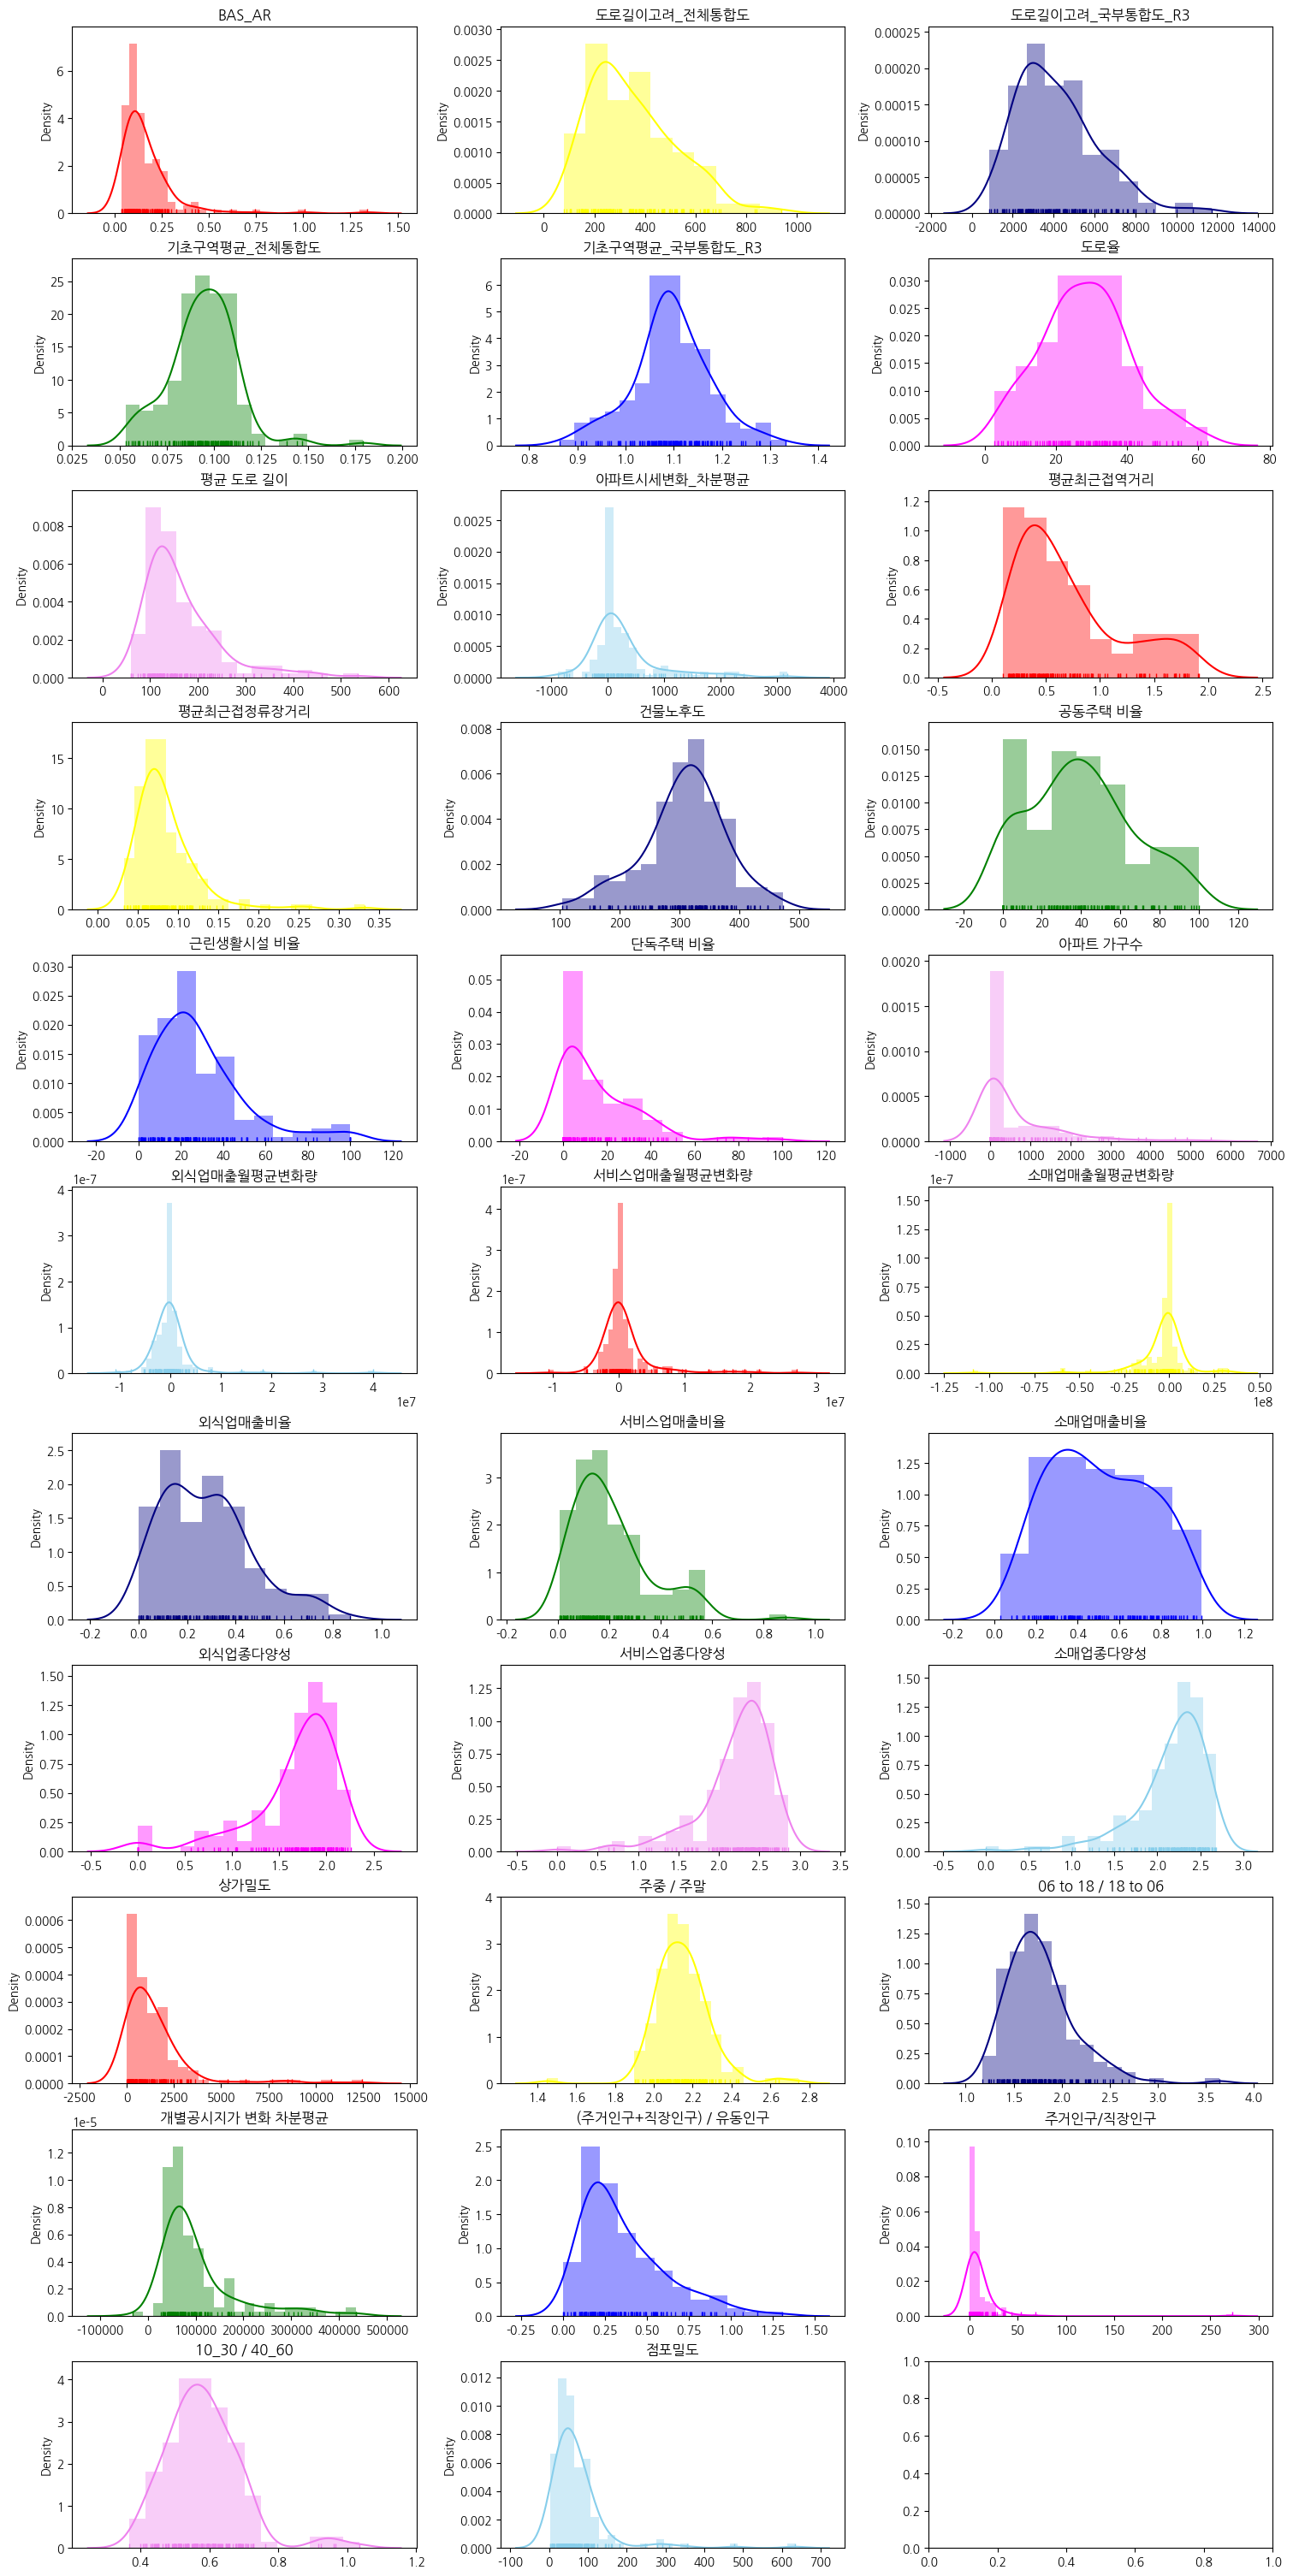

In [147]:
ind_var_col = list(range(1,9)) + list(range(11,35))
dX = clean_data.iloc[:,ind_var_col]

col_list = list(dX)
nrows = int(len(col_list)/3)+1
ncols = 3

fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(15,30),constrained_layout=True)
color = ['red','yellow','navy','green','blue','magenta','violet','skyblue']


for i in range(nrows):
    for j in range(ncols):
        if (ncols*i+j) == len(col_list):
            break
        
        sns.distplot(ax=axes[i,j], x=dX[col_list[(ncols*i+j)]], kde=True,color=color[(ncols*i+j) % len(color)],rug=True)
        axes[i,j].set_title(col_list[ncols*i+j])
        axes[i,j].set_facecolor('white')

plt.show()

## 1.4 상관관계

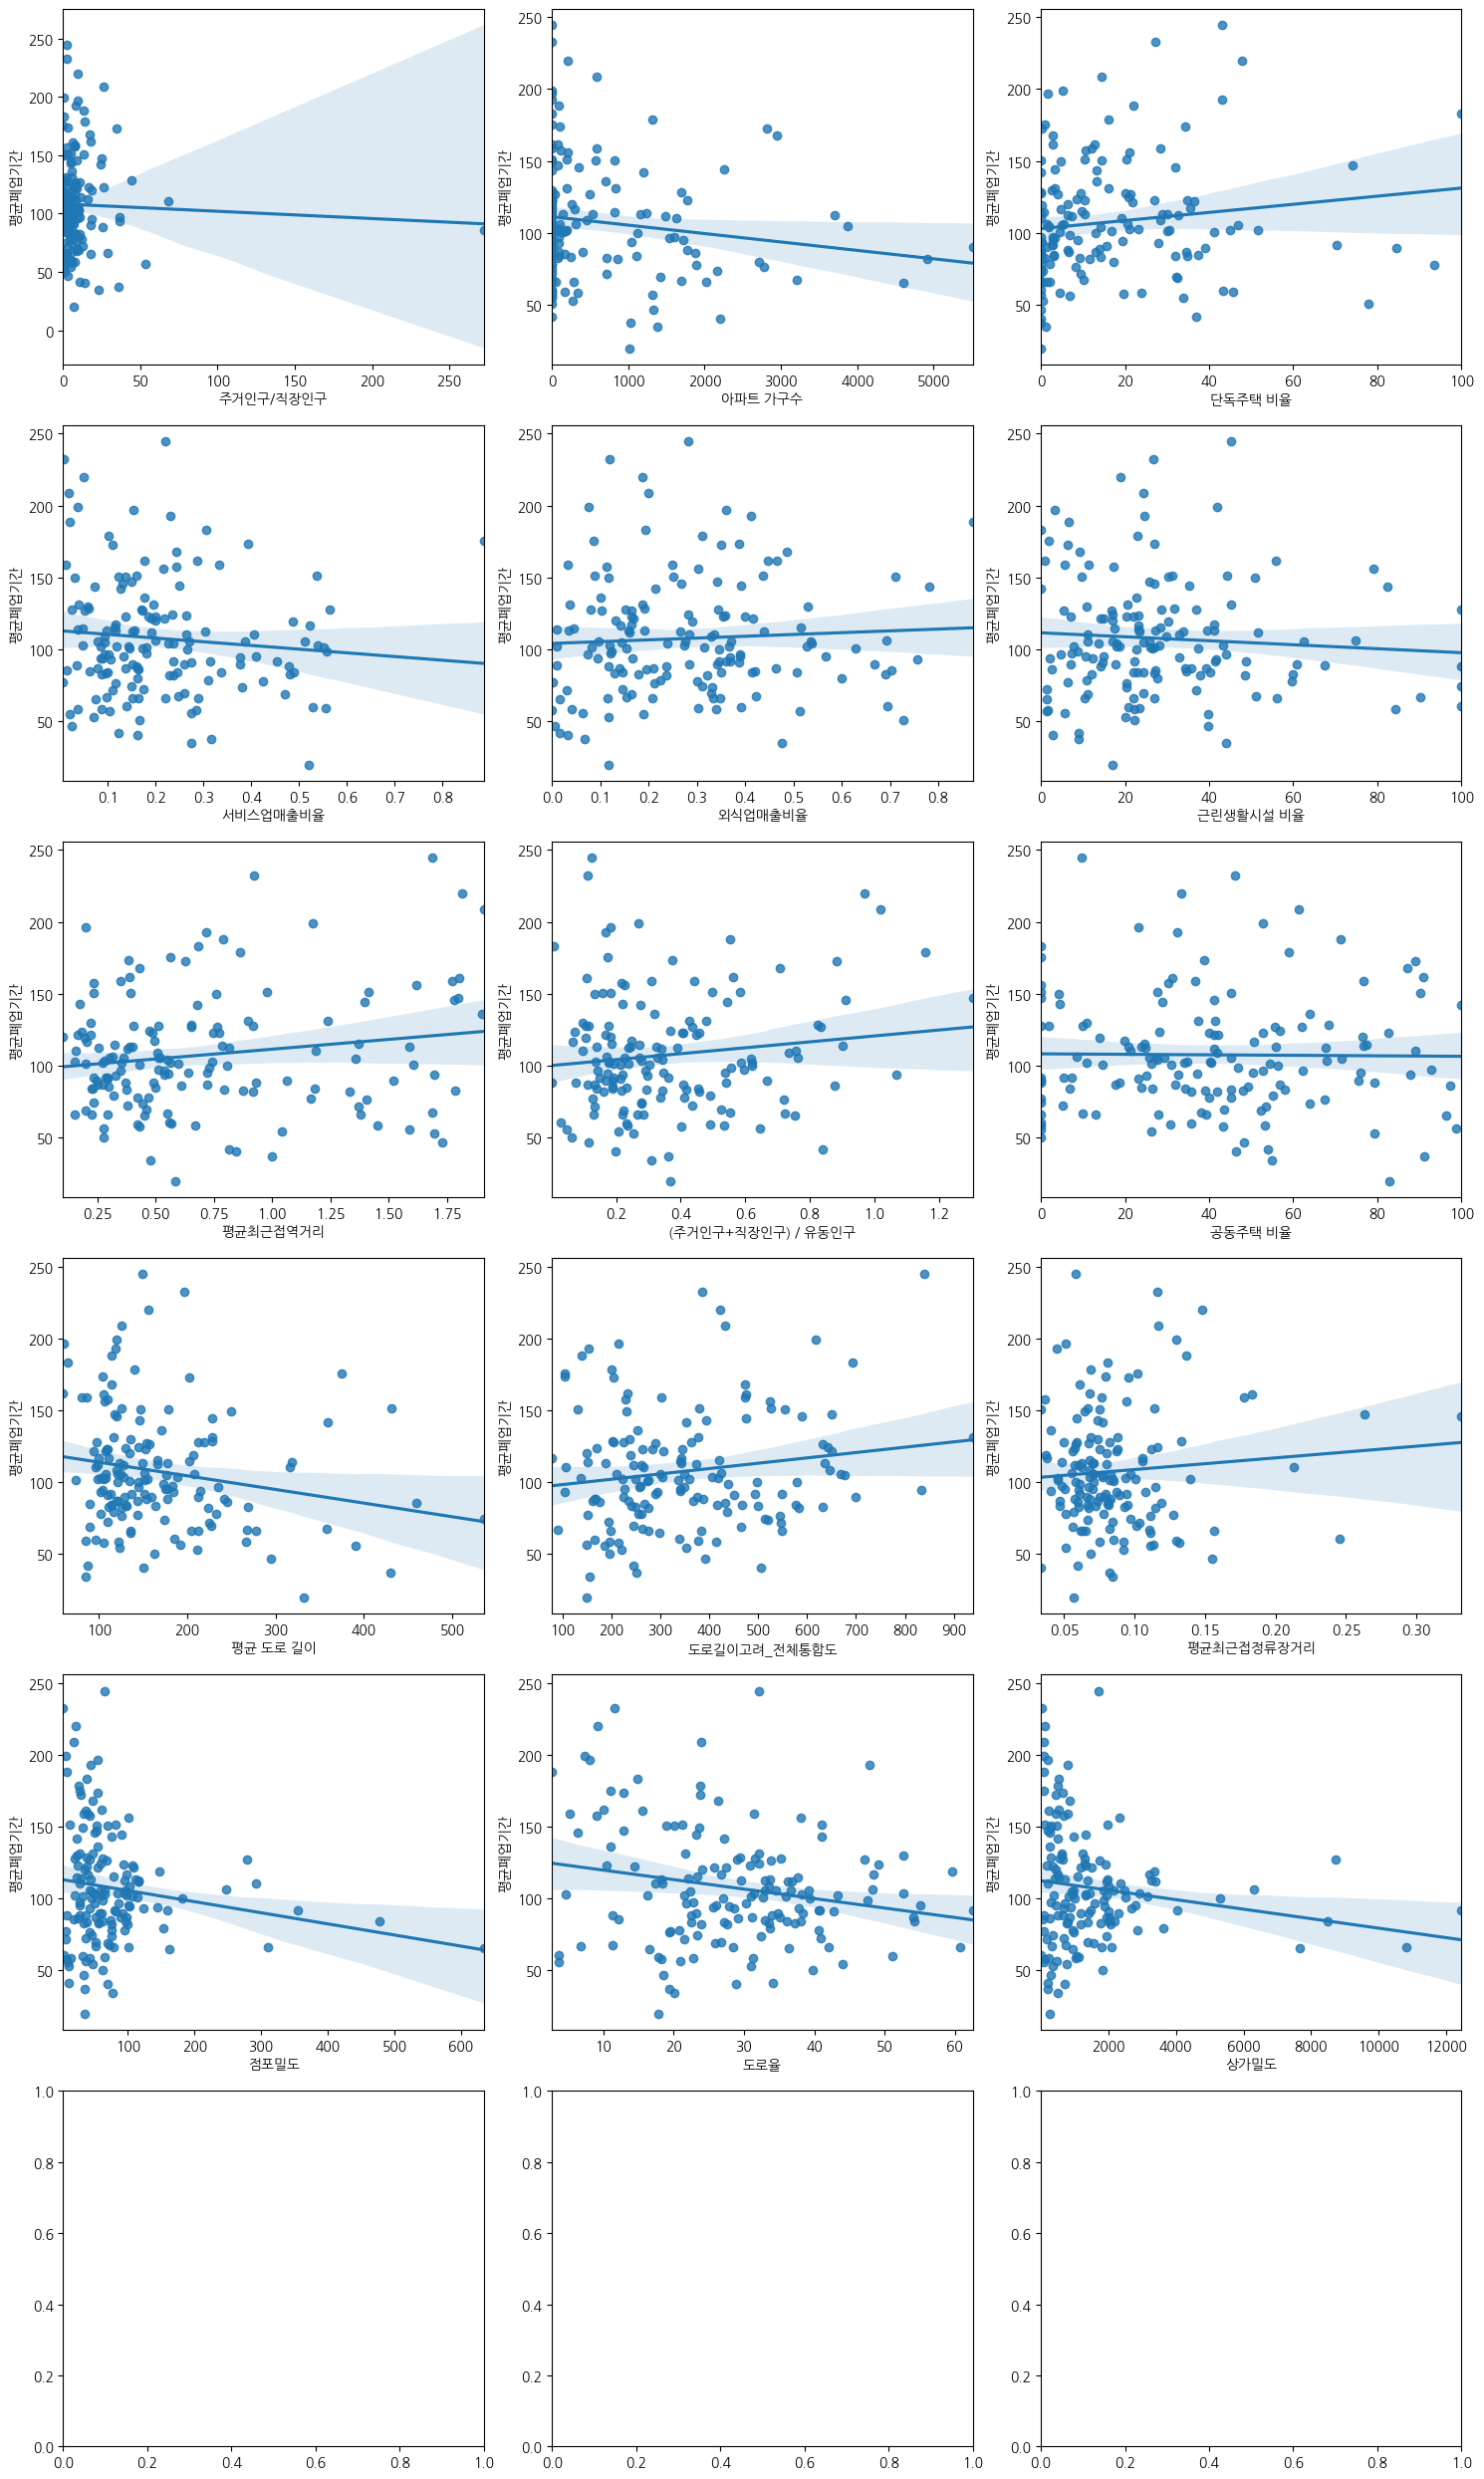

In [191]:
# mul_col = clean_data.iloc[:,ind_var_col].columns
# ['BAS_AR', '서비스업매출월평균변화량', '아파트시세변화_차분평균',
#    '외식업매출월평균변화량', '외식업매출비율', '근린생활시설 비율', '단독주택 비율']

fig, axes = plt.subplots(nrows=int(len(remove_vif.features.values)/3)+1,ncols=3,figsize=(15,25))

for idx, col in enumerate(remove_vif.features.values):
    sns.regplot(x=col,y='평균폐업기간',data=clean_data,ax=axes[int(idx/3),idx % 3])

plt.tight_layout()
plt.show()

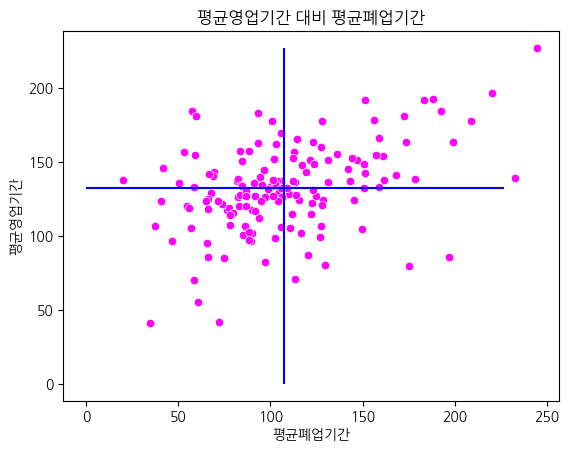

In [148]:
sns.scatterplot(data=clean_data,x='평균폐업기간',y='평균영업기간',color='magenta',palette='deep')
plt.title('평균영업기간 대비 평균폐업기간')
plt.style.use({'figure.facecolor':'white'})
plt.hlines(clean_data['평균영업기간'].mean(),0,clean_data['평균영업기간'].max(),color='blue')
plt.vlines(clean_data['평균폐업기간'].mean(),0,clean_data['평균영업기간'].max(),color='blue')
plt.show()

## 1.5 다중공선성

In [149]:
def check_vif(dX):
    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(dX.values,i) for i in range(dX.values.shape[1])] 
    vif['features'] = dX.columns
    vif = vif.sort_values("VIF Factor").reset_index(drop=True)
    
    return vif

result = check_vif(clean_data.iloc[:,ind_var_col])
result.iloc[-10:,]

,VIF Factor,features
22,4.633343,06 to 18 / 18 to 06
23,5.226764,10_30 / 40_60
24,5.701186,점포밀도
25,6.677420,상가밀도
26,6.920792,기초구역평균_전체통합도
27,34.653716,도로길이고려_국부통합도_R3
28,35.711910,도로길이고려_전체통합도
29,69.053651,서비스업매출비율
30,129.818600,외식업매출비율
31,326.355297,소매업매출비율


In [150]:
def RFE(df):
    flag = True
    next_col = list(df.columns)
    
    while flag:
        local = df.loc[:,next_col]
        result = check_vif(local)

        if len(result[result['VIF Factor'] > 10]) == 0:
            return result # 유일한 탈출 조건
        
#         display(result[-7:])
        next_col = result.iloc[:-1,1].values.tolist()
        
vif_result = RFE(dX)
optimal_feature = vif_result['features'].values.tolist()
optimal_feature

['외식업매출월평균변화량',
 '아파트시세변화_차분평균',
 '소매업매출월평균변화량',
 '서비스업매출월평균변화량',
 '주거인구/직장인구',
 '아파트 가구수',
 '단독주택 비율',
 '서비스업매출비율',
 '외식업매출비율',
 '평균최근접역거리',
 '근린생활시설 비율',
 'BAS_AR',
 '개별공시지가 변화 차분평균',
 '(주거인구+직장인구) / 유동인구',
 '공동주택 비율',
 '평균 도로 길이',
 '도로길이고려_국부통합도_R3',
 '점포밀도',
 '상가밀도',
 '평균최근접정류장거리']

# 2. 지리가중회귀분석(MGWR)

## 2.1 독립변수, 종속변수 설정

In [151]:
drop_list = [col for col in list(dX) if '변화' in col]
drop_list += ['건물노후도','BAS_AR','BAS_ID','x','y','평균폐업기간','평균영업기간','geometry']
try_data = clean_data.drop(drop_list,axis=1)

In [152]:
remove_vif = RFE(try_data)

In [188]:
list(remove_vif.features.values)

['주거인구/직장인구',
 '아파트 가구수',
 '단독주택 비율',
 '서비스업매출비율',
 '외식업매출비율',
 '근린생활시설 비율',
 '평균최근접역거리',
 '(주거인구+직장인구) / 유동인구',
 '공동주택 비율',
 '평균 도로 길이',
 '도로길이고려_전체통합도',
 '평균최근접정류장거리',
 '점포밀도',
 '도로율',
 '상가밀도']

In [155]:
scaler = MinMaxScaler()
mm_scaled_dX = pd.DataFrame(scaler.fit_transform(try_data.loc[:,remove_vif['features'].values])
                            ,columns=remove_vif['features'].values)
s_X = mm_scaled_dX.values

In [ ]:
# ind_var_col = list(range(1,9)) + list(range(11,34))

s_y1 = clean_data['평균영업기간'].values.reshape((-1,1)) # 종속변수1
s_y2 = clean_data['평균폐업기간'].values.reshape((-1,1)) # 종속변수2

# 다중공선성 제거
# s_X= clean_data.loc[:,['아파트 가구수', '(주거인구+직장인구) / 유동인구', '평균 도로 길이', '도로길이고려_전체통합도',
#                        '도로율']].values

# Raw Data
# s_X = clean_data.iloc[:,ind_var_col].values

s_X = try_data.loc[:,remove_vif['features'].values].values

# 회귀계수 다중공선성 제거
# # 데이터 다중공선성 제거된 컬럼에서 시작함
# local_mul_col = ['단독주택 비율', '소매업매출월평균변화량', '주거인구/직장인구', '평균최근접정류장거리', '서비스업매출비율',
#                  '외식업매출월평균변화량', '평균최근접역거리', 'BAS_AR', '근린생활시설 비율']
#
# s_X = clean_data.loc[:,local_mul_col].values

# 회귀계수 다중공선성 제거, 원래 데이터에서 시작
# local_mul_col = ['단독주택 비율', '주거인구/직장인구', '소매업매출월평균변화량', '개별공시지가 변화 차분평균',
#        '평균최근접정류장거리', '평균최근접역거리', '외식업매출월평균변화량', '서비스업매출비율', 'BAS_AR']
#
# s_X = clean_data.loc[:,local_mul_col].values

# 왜도 2이상인 데이터 log변환 후, standard scaling 함
# s_X= ss_scaled_dX.values


# 왜도 2이상인 데이터 log변환 후, standard scaling, 다중공선성 제거
# s_X= ss_scaled_dX.loc[:,optimal_feature].values

# s_X = rm_avg_X.values

# p-value 0.5 이상 지워보자
# drop_col = [0,1,2,9,10,13,15]
# drop_col = [optimal_feature[i] for i in range(len(optimal_feature)) if i in drop_col]
# s_X= ss_scaled_dX.loc[:,optimal_feature]
# s_X = s_X.drop(drop_col,axis=1).values

    
u = clean_data['x'] # 경도
v = clean_data['y'] # 위도
s_coords = list(zip(u,v))

s_X.shape

## 2.2 MODELING

In [156]:
#Calibrate MGWR model

mgwr_selector = Sel_BW(s_coords, s_y2, s_X,multi=True,kernel='exponential',spherical=True)
mgwr_bw = mgwr_selector.search(multi_bw_min=[2])
print(mgwr_bw)
mgwr_model = MGWR(s_coords, s_y2, s_X, mgwr_selector,kernel='exponential',spherical=True)
mgwr_results = mgwr_model.fit()

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[150. 150. 150. 138. 148. 150. 150.  24. 150. 150. 147.  94. 150. 150.
 150. 150.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [157]:
mgwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 151
Number of covariates:                                                    16

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         195075.801
Log-likelihood:                                                    -755.131
AIC:                                                               1542.263
AICc:                                                              1548.864
BIC:                                                             194398.468
R2:                                                                   0.220
Adj. R2:                                                              0.134

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [ ]:
mgwr_coef_df = pd.DataFrame(mgwr_results.params)
mgwr_coef_df.columns = ['intercept']+remove_vif.features.values.tolist()
mgwr_coef_df['x'] = u
mgwr_coef_df['y'] = v
mgwr_coef_df['BAS_ID'] = clean_data['BAS_ID']
mgwr_coef_df.to_csv('../data/전처리 파일/회귀계수/MGWR 회귀계수(평균폐업기간,mm,expo,data_1222).csv',index=False,encoding='euc-kr')

In [166]:
mgwr_coef_df = pd.DataFrame(mgwr_results.params)
mgwr_coef_df.columns = ['intercept']+list(remove_vif.features.values)

In [187]:
agg_coef = mgwr_coef_df.describe()

,intercept,주거인구/직장인구,아파트 가구수,단독주택 비율,서비스업매출비율,외식업매출비율,근린생활시설 비율,평균최근접역거리,(주거인구+직장인구) / 유동인구,공동주택 비율,평균 도로 길이,도로길이고려_전체통합도,평균최근접정류장거리,점포밀도,도로율,상가밀도
0,151.264879,-5.238827,-46.911252,-20.844823,-11.341123,17.774693,-19.926163,23.390043,40.270026,-23.026908,-37.479826,37.653454,-38.080706,-49.805779,-60.447495,21.965062
1,151.035092,-5.543051,-46.470206,-22.109593,-11.612787,17.337794,-20.014619,18.105730,40.085887,-23.616709,-38.245800,36.372476,-38.946650,-50.106434,-60.704185,21.886960
2,150.976756,-5.731691,-46.108959,-22.975735,-11.729160,17.125273,-20.061096,18.012791,40.117643,-23.637341,-38.237395,35.541592,-39.254053,-50.185732,-60.641445,21.934654
3,151.083284,-5.605787,-46.398559,-22.242451,-11.479891,17.395410,-20.026757,20.790439,40.107657,-23.411511,-37.904206,36.204107,-38.917310,-49.813567,-60.520392,22.058178
4,151.013013,-5.786546,-46.069467,-23.098041,-11.634563,17.130483,-20.159779,19.851785,40.160051,-23.509329,-37.941858,35.424835,-39.348700,-49.765520,-60.510959,22.082958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,151.395115,-7.438801,-50.778131,-18.634023,-10.220309,19.778145,-24.971379,23.228574,35.457602,-22.120099,-34.602698,31.088007,-42.011067,-47.627029,-58.895796,21.810539
147,151.531921,-6.795386,-50.743120,-17.318772,-9.918154,20.171147,-24.620378,28.450677,35.785188,-21.863470,-34.442564,31.943651,-41.266300,-47.589110,-58.634670,21.939653
148,150.961595,-8.153860,-49.277348,-24.535644,-10.677632,18.598955,-25.510162,2.952195,35.937287,-23.220756,-35.284842,26.295302,-44.976936,-45.484527,-59.534403,23.966985
149,150.411583,-8.791076,-48.105093,-28.958609,-13.716084,17.876986,-24.165716,-18.577073,35.737319,-24.364403,-38.555009,24.719201,-46.410943,-45.332648,-60.020664,24.702902


In [167]:
agg_coef = mgwr_coef_df.describe()
agg_coef_T = agg_coef.loc[['min','max','mean','std'],:].transpose()
agg_coef_T
agg_coef_T.to_csv('../data/전처리 파일/회귀계수/회귀계수 통계량(평균폐업기간).csv',encoding='euc-kr')

### 2.2.1 잔차 Moran's I

In [168]:
gdf = pd.DataFrame(clean_data.loc[:,'geometry'],columns=['geometry'])

y = mgwr_results.resid_response
w = Queen.from_dataframe(gdf)

moran = Moran(y, w,permutations=9999)
moran.I

-0.056752155052212525

In [169]:
print('{:.5f}'.format(moran.p_sim))
# 귀무가설을 기각할 수 없으므로 공간적으로 상관성이 없다고 말할 수 있다.

0.14660


In [214]:
import statsmodels.api as sm

X = mm_scaled_dX
    # try_data.loc[:,remove_vif['features'].values]
X = sm.add_constant(X)
y = clean_data.loc[:,'평균폐업기간'].values

ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     2.545
Date:                Thu, 23 Dec 2021   Prob (F-statistic):            0.00231
Time:                        16:48:11   Log-Likelihood:                -755.13
No. Observations:                 151   AIC:                             1542.
Df Residuals:                     135   BIC:                             1591.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                148.9697     22.992      6.479      0.000     103.499     194.441
주거인구/직장인구             -2.4361     41.479     -0.059      0.953     -84.468      79.596
아파트 가구수              -57.0800     21.023     -2.715      0.007     -98.658     -15.502
단독주택 비율              -24.1991     21.822     -1.109      0.269     -67.357      18.959
서비스업매출비율             -15.4469     19.321     -0.799      0.425     -53.658      22.764
외식업매출비율               22.9606     15.078      1.523      0.130      -6.860      52.781
근린생활시설 비율            -16.4268     19.625     -0.837      0.404     -55.239      22.385
평균최근접역거리              15.6185     13.372      1.168      0.245     -10.827      42.064
(주거인구+직장인구) / 유동인구    41.3806     20.902      1.980      0.050       0.043      82.719
공동주택 비율              -23.4969     20.375     -1.153      0.251     -63.792      16.798
평균 도로 길이             -48.7779     21.677     -2.250      0.026     -91.649      -5.907
도로길이고려_전체통합도          35.1665     17.136      2.052      0.042       1.277      69.056
평균최근접정류장거리           -42.8641     27.813     -1.541      0.126     -97.870      12.142
점포밀도                 -36.5853     51.472     -0.711      0.478    -138.381      65.211
도로율                  -62.7058     20.887     -3.002      0.003    -104.013     -21.399
상가밀도                   9.6981     48.026      0.202      0.840     -85.283     104.680
==============================================================================
Omnibus:                        8.120   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                7.877
Skew:                           0.506   Prob(JB):                       0.0195
Kurtosis:                       3.477   Cond. No.                         31.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [185]:
gdf = pd.DataFrame(clean_data.loc[:,'geometry'],columns=['geometry'])
# y = clean_data['평균영업기간'].values

y = results.resid
w = Queen.from_dataframe(gdf)

moran = Moran(y, w,permutations=999)
moran.I

0.04140973296809754

In [186]:
moran.p_sim

0.169

### 2.2.2 local collinearity

In [170]:
cc = pd.Series(mgwr_results.local_collinearity()[0].flatten())
cc.sort_values(ascending=False)

16     26.856607
17     26.815632
27     26.807733
19     26.791711
18     26.770025
         ...    
150    24.333555
123    24.315110
122    24.271636
97     24.269217
121    24.169170
Length: 151, dtype: float64

### 2.2.3 Optimal Max Bandwidth

In [ ]:
store_path = '../data/전처리 파일/가중치행렬(mgwr,f3,120)'
bandwidth = []
aicc = []
r2 = []
ll = []
start = 120
end = 121
step = 1

for bw in range(start,end,step):
    mgwr_bw = bw
    mgwr_model = MGWR(s_coords, s_y1, s_X, gwr_bw,kernel='f3',spherical=True)
    mgwr_results = mgwr_model.fit()
    print('='*30+' RESULT '+'='*30)
    print('Bandwidth : {}, R2 : {:3f}, Log-Likelihood : {:3f}, AICc : {:.3f}'.format(bw,mgwr_results.R2,
                                                                              mgwr_results.llf,mgwr_results.aicc))
    bandwidth.append(bw)
    aicc.append(mgwr_results.aicc)
    r2.append(mgwr_results.R2)
    ll.append(mgwr_results.llf)
#     p_val = spatial_variability(gwr_model,bw,n_iters=1000)
#     print('유의 확률 30% : {}'.format(len(p_val[p_val < 0.3])))
    
#     gwr_coef_df = pd.DataFrame(gwr_results.params)
#     gwr_coef_df.columns = ['intercept']+list(clean_data.iloc[:,ind_var_col].columns)
#     gwr_coef_df['x'] = u
#     gwr_coef_df['y'] = v
#     gwr_coef_df['BAS_ID'] = clean_data['BAS_ID']
#     gwr_coef_df.to_csv('../data/전처리 파일/회귀계수/BW별 회귀계수(AICc)/GWR 회귀계수(평균영업기간,bw_'+str(bw)+',1111).csv',index=False,encoding='euc-kr')
    weight = pd.DataFrame(mgwr_results.W[2],columns=clean_data['BAS_ID'],index=clean_data['BAS_ID'])
    weight.to_csv(os.path.join(store_path,'weight('+str(bw)+',f3).csv'),encoding='euc-kr')

aicc_by_bw = pd.DataFrame({'band width':bandwidth,'R2':r2,'Log-Likelihood':ll,'AICc':aicc})

In [ ]:
# Band width에 따른 AICc 그래프
sns.scatterplot(x=aicc_by_bw['band width'],y=aicc_by_bw['AICc'],color='magenta')
plt.show()

In [ ]:
diff_aicc = pd.DataFrame({'Interval':range(0,len(aicc_by_bw['AICc'])-1),'diff':abs(np.diff(aicc_by_bw['AICc']))})

In [ ]:
# AICc 감소폭 그래프

sns.scatterplot(x=diff_aicc['Interval'],y=diff_aicc['diff'],color='violet')
plt.show()

### 2.2.4 Column별 회귀계수 분포

In [224]:
coef_ols = pd.DataFrame({'columns':['const']+list(remove_vif.features.values)
                 ,'coef':results.params})

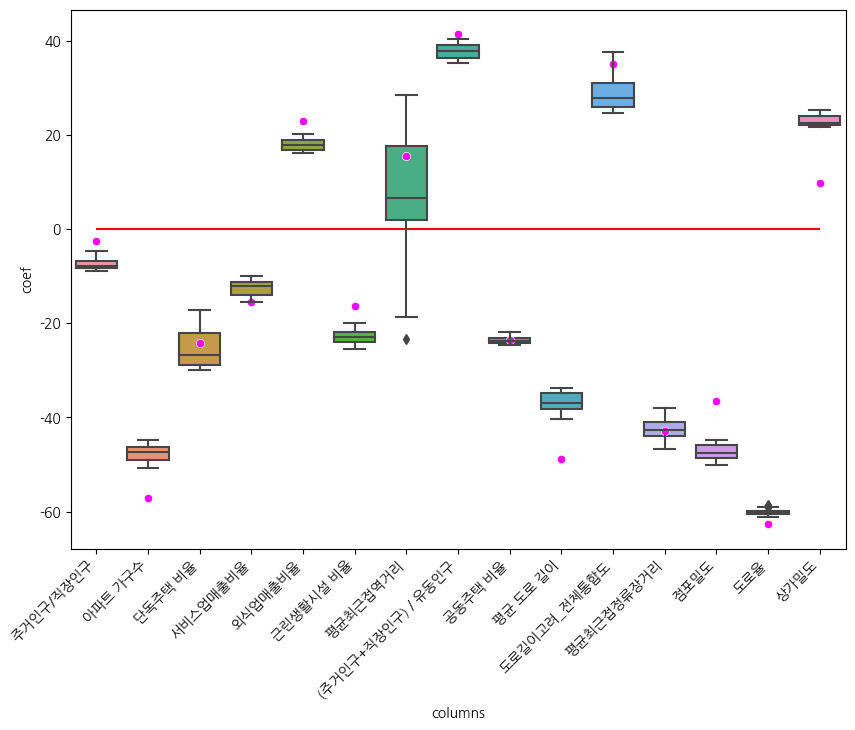

In [228]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,7))

sns.boxplot(data=mgwr_coef_df.iloc[:,1:],ax=ax)
sns.scatterplot(x='columns',y='coef',data=coef_ols.iloc[1:,:],color='magenta',ax=ax)
ax.set_xticklabels(mgwr_coef_df.columns[1:], rotation=45, ha='right')
ax.hlines(y=0,color='red',xmin=0,xmax=14)

plt.savefig('../data/결과 이미지/회귀계수 boxplot(평균폐업기간).jpg')
plt.show()

In [ ]:
coef_df_list = [] # bw별 회귀계수 data frame list, tuple로 저장할것(bandwidth, coef_df)
coef_df_by_col_list = [] # column별 회귀계수 dataframe list
start = 80
end = 130
step = 2

# bw별로 회귀계수 dataframe 생성
for bw in range(start,end,step):
    mgwr_selector = Sel_BW(s_coords, s_y1, s_X,multi=True,kernel='bisquare',spherical=True)
    mgwr_bw = mgwr_selector.search(multi_bw_min=[2],multi_bw_max=[bw])
    mgwr_model = MGWR(s_coords, s_y1, s_X, mgwr_bw_selector,kernel='bisquare',spherical=True)
    mgwr_results = mgwr_model.fit()
    
    mgwr_coef_df = pd.DataFrame(mgwr_results.params)
    mgwr_coef_df.columns = ['intercept']+list(clean_data.iloc[:,ind_var_col].columns)
    mgwr_coef_df['BAS_ID'] = clean_data['BAS_ID']
    coef_df_list.append(tuple((bw,mgwr_coef_df)))

# column별 회귀계수 dataframe list 생성
for i in range(32): 
    coef_df_by_col_list.append(pd.DataFrame(columns=range(start,end,step),index=clean_data['BAS_ID']))

# loop 돌면서 각 컬럼별, bw별 dataframe을 생성
for bw,coef_df in coef_df_list:
    for i in range(32):
        coef_df_by_col_list[i].loc[:,bw] = coef_df.iloc[:,i].values

In [ ]:
bas_id_list = list(clean_data['BAS_ID'])
store_path = '../data/전처리 파일/회귀계수/Column별'

for col in tqdm(list(dX)): 
    if '/' in col:
        col_path = col.replace('/',',')
    else:
        col_path = col
        
    if not os.path.isdir(os.path.join(store_path,col_path)):
        os.mkdir(os.path.join(store_path,col_path))
    
    col_idx = dX.columns.values.tolist().index(col)+1
    target = coef_df_by_col_list[col_idx]
    
    for bas_id in bas_id_list:
        # min값과 max값의 부호가 다른 경우에만 그래프 저장 실행
        if (target.loc[bas_id].min()*target.loc[bas_id].max()) > 0:
            continue
            
        sns.histplot(x=target.loc[bas_id], kde=True,color='violet')
        plt.title(bas_id)
        plt.savefig(os.path.join(store_path,col_path,bas_id+'.png'))
        plt.cla()

In [ ]:
dir_list = os.listdir(store_path)
count = []
for dir_name in dir_list:
    file_num = len(os.listdir(os.path.join(store_path,dir_name)))
    count.append(file_num)
#     print('{} : {}'.format(dir_name,file_num))
    
count_df = pd.Series(count,index=dir_list)
count_df.sort_values(ascending=False)

### 2.2.5 Restriction Distance

In [ ]:
def local_cdist(coords_i, coords, spherical):
    """
    Compute Haversine (spherical=True) or Euclidean (spherical=False) distance for a local kernel.
    """
    if spherical:
        dLat = np.radians(coords[:, 1] - coords_i[1])
        dLon = np.radians(coords[:, 0] - coords_i[0])
        lat1 = np.radians(coords[:, 1])
        lat2 = np.radians(coords_i[1])
        a = np.sin(
            dLat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dLon / 2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        R = 6371.0
        return R * c
    else:
        return np.sqrt(np.sum((coords_i - coords)**2, axis=1))

In [ ]:
bw_list = range(10,151,10)
pos_count = 151
coords = np.array(s_coords)
eps = 1.0000001

df = pd.DataFrame({'BAS_ID':clean_data['BAS_ID']})

for bw in bw_list:
    max_dis_list = []
    for i in range(pos_count): 
        dis_list = local_cdist(coords[i],coords,True)
        max_dis = np.partition(dis_list,int(bw) - 1)[int(bw) - 1] * eps  #partial sort in O(n) Time
#         print(max_dis)
        max_dis_list.append(max_dis)
    
    df[str(bw)] = max_dis_list

max_dis_list = []
for i in range(pos_count):
    dis_list = local_cdist(coords[i],coords,True)
    max_dis = np.partition(dis_list,int(151) - 1)[int(151) - 1] * eps  #partial sort in O(n) Time
#         print(max_dis)
    max_dis_list.append(max_dis)
    
df['151'] = max_dis_list

df.head()

In [ ]:
sns.boxplot(data=df.loc[:,'90':])
plt.savefig('../data/결과 이미지/restrict_bw(평균폐업기간).jpg')
plt.show()

In [ ]:
dist_Q3 = dict(df.describe().loc['75%'])
dist_Q2 = dict(df.describe().loc['50%'])
# max_dist_dict = dist_Q3
max_dist_dict = dist_Q2
max_dist_dict

In [ ]:
temp_bw = []

for bw in range(10,152):
  
    start_bw = int(bw / 10)*10
    start_dist = max_dist_dict[str(int(start_bw))]
    if start_bw != 150:

        temp_bw.append(start_dist+(max_dist_dict[str(int(start_bw)+10)]-start_dist)/10*(bw-start_bw))
    else:
        temp_bw.append(start_dist+(max_dist_dict[str(int(start_bw)+1)]-start_dist)/1*(bw-start_bw))
    
distance_by_bw = pd.DataFrame({'bw':range(10,152),'distance':temp_bw})

In [ ]:
sns.scatterplot(x=distance_by_bw['bw'],y=distance_by_bw['distance'])
plt.savefig('../data/결과 이미지/restrict_bw_smooth_graph(평균폐업기간).jpg')
plt.show()

### 2.2.6 Recursive Local Multicollinearity Elimination 

In [ ]:
def coef_RFE(df):
    flag = True
    next_col = list(df.columns)
    
    while flag:
        
        temp_X = df.loc[:,next_col].values
    
        mgwr_selector = Sel_BW(s_coords, s_y2, temp_X,multi=True,kernel='f2',spherical=True)
        mgwr_bw = mgwr_selector.search(multi_bw_min=[2])
        print(mgwr_bw)
        mgwr_model = MGWR(s_coords, s_y2, temp_X, mgwr_selector,kernel='f2',spherical=True,hat_matrix=True)
        mgwr_results = mgwr_model.fit()
    
        mgwr_coef_df = pd.DataFrame(mgwr_results.params)
        mgwr_coef_df.columns = ['intercept']+next_col
    
        result = check_vif(mgwr_coef_df.iloc[:,1:])
        display(result.iloc[-3:,:])

        if len(result[result['VIF Factor'] > 10]) == 0:
            return mgwr_results, result
            # 유일한 탈출 조건
        
        next_col = result.iloc[:-1,1].values.tolist()
        
result, last_feature = coef_RFE(clean_data.loc[:,remove_vif['features']])

In [ ]:
last_feature.to_csv('../data/결과 데이터/회귀계수 간 VIF(평균폐업기간)',encoding='euc-kr')

In [ ]:
list(last_feature['features'].values)

In [ ]:
local_con_num = pd.Series(result.local_collinearity()[0].flatten())
local_con_num.sort_values()

## 2.3 Kernel별 GWR Modeling
- bisquare, f1, gaussian
- max bandwidth : 120, 거리제한 O
- 대역폭은 고정되어 있고, 커널별 가중치 자료가 필요한 것이기 때문에 굳이 시간이 오래걸리는 MGWR모델이 아닌 GWR 모델을 생성하여 가중치 자료를 생성

In [ ]:
# 1. Raw Data
rd_X = clean_data.iloc[:,ind_var_col]

ind_dataset = [rd_X]
# [rd_X,remove_high_vif_X,scaled_X,remove_high_vif_scaled_X]
kernel = ['f1']
# ,'bisquare']
# ,'f2','f3','gaussian','exponential','bisquare']
max_multi_bw = [80]
# [90,100,110,120]

aicc = []
mbw = []
r2 = []
adj_r2 = []
ker = []
dataset_idx = []
count = 0
start_time = time.time()

for func in kernel:
    for bw in max_multi_bw:
        for i,s_X in enumerate(ind_dataset):
            s_X = s_X.values
            # 모델 생성

#             gwr_selector = Sel_BW(s_coords, s_y1, s_X,kernel=func,spherical=True)
#             gwr_bw = gwr_selector.search(bw_min=[2],multi_bw_max=[bw])
#             print(mgwr_bw)
            gwr_model = GWR(s_coords, s_y2, s_X, bw ,kernel=func,spherical=True)
            gwr_results = gwr_model.fit()
    
            # 평가 지표
            aicc.append(gwr_results.aicc)
            mbw.append(bw)
            r2.append(gwr_results.R2)
            adj_r2.append(gwr_results.adj_R2)
            ker.append(func)
            dataset_idx.append(i)
            weight = pd.DataFrame(gwr_results.W,columns=clean_data['BAS_ID'],index=clean_data['BAS_ID'])
            weight.to_csv('../data/전처리 파일/가중치행렬/weight('+str(bw)+',폐업,f1,1123).csv',encoding='euc-kr')
            
            print('========================= RESULT =========================')
            print('KERNEL : {}'.format(func))
            print('DATASET NUMBER : {}'.format(i))
            print('R2 : {:.8f}'.format(gwr_results.R2))
            print('Adj. R2 : {:.8f}'.format(gwr_results.adj_R2))
            print('AICc : {:.8f}'.format(gwr_results.aicc))
            print('MAX BANDWIDTH : {:.8f}'.format(bw))
    
            count += 1
            print('진행률 : {0:.2f}%, 소요시간 : {1:.2f}분'.format(count/(len(kernel)*len(ind_dataset)*len(max_multi_bw))*100,(time.time()-start_time)/60))

valid_result = pd.DataFrame({'Data Number':dataset_idx,'Kernel':ker,'R2':r2,'Adj. R2':adj_r2
                             ,'AICc':aicc,'Max Bandwidth':mbw})

## 2.4 거리제한에 따른 회귀계수의 비교

In [ ]:
coef_dir = os.listdir('../data/전처리 파일/회귀계수')
coef_dir

In [ ]:
not_restrict = pd.read_csv('../data/전처리 파일/회귀계수/MGWR 회귀계수(평균폐업기간,max_bw_120,거리제한 X,renew f1,1118).csv',encoding='euc-kr')
restrict = pd.read_csv('../data/전처리 파일/회귀계수/MGWR 회귀계수(평균폐업기간,max_bw_120,renew f1,1119).csv',encoding='euc-kr')

In [ ]:
not_restrict = not_restrict.drop(['x','y'],axis=1)
restrict = restrict.drop(['x','y'],axis=1)
display(not_restrict.head())
display(restrict.head())

In [ ]:
not_restrict_val = not_restrict.iloc[:,:-1].values
restrict_val = restrict.iloc[:,:-1].values
coef_diff = not_restrict_val-restrict_val
coef_diff = pd.DataFrame(coef_diff,columns=restrict.columns[:-1])
coef_diff['BAS_ID'] = restrict['BAS_ID']
coef_diff.head()

In [ ]:
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [ ]:
display(not_restrict.agg(['min','max']))
display(restrict.agg(['min','max']))

In [ ]:
path = '../data/군집화 결과/renew_f1(영업기간,maxbw120,1118).csv'
cluster_data = pd.read_csv(path,encoding='euc-kr')
cluster_data.head()

In [ ]:
merge_restrict = pd.concat([restrict,cluster_data['open_11cluster']],axis=1)
merge_not_restrict = pd.concat([not_restrict,cluster_data['open_11cluster']],axis=1)

In [ ]:
sorted(cluster_data['open_11cluster'].unique())

In [ ]:
merge_not_restrict['open_11cluster'].unique()

In [ ]:
# 중간 위치의 기초구역 리스트
# 21314, 21315, 21334, 21363, 21376
# 해당 기초구역들만 다른 색으로 표시해보자
store_path = '../data/전처리 파일/회귀계수/거리제한 전후 회귀계수 비교'
# inter_area = [21314, 21315, 21334, 21363, 21376]
# idx = restrict[restrict['BAS_ID'].isin(inter_area)].index

if not os.path.exists(store_path):
    os.mkdir(store_path)

for i,col in enumerate(restrict.columns[0:1]):
    if '/' in col:
        col_path = col.replace('/',',')
    else:
        col_path = col
        
    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(20,7),sharey=True)
    
    sns.scatterplot(x='BAS_ID',y=col,data = merge_not_restrict,hue='open_11cluster',ax=axes[0],palette="Paired")
    sns.scatterplot(x='BAS_ID',y=col,data = merge_restrict,hue='open_11cluster',ax=axes[1],palette="Paired")
    axes[0].set_title('NOT RESTRICT')
    axes[1].set_title('RESTRICT')
    plt.savefig(os.path.join(store_path,col_path))

In [ ]:
path = '../data/전처리 파일/가중치행렬/가중치행렬(bw별, 거리제한 O)'
weight_name = os.listdir(path)
weight = pd.read_csv(os.path.join(path,weight_name[2]),encoding='euc-kr')

In [ ]:
use_weight = weight[weight > 0].count()
len(use_weight[use_weight < 80])